In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

# FUSE Client

1 server and 2 clients

In [10]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_delta(files):
    r = []
    o = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)       
            r.append(to_seconds(data['delta']))
            try:
                o.append(float(data['stdout']))
            except:
                o.append(0)
    return r, o

# Decoupled vs. Normal Namespaces

   allow (CudeleFS)  interfere (from Fig 5b)  block (CudeleFS)  \
0          1.706266                 1.728460          1.134465   
1          1.691906                 1.710183          1.266319   
2          1.873368                 1.926240          1.536227   
3          2.033943                 2.044909          1.933159   
4          2.281549                 2.293299          2.277633   

   isolated (from Fig 5b)  
0                1.143603  
1                1.288077  
2                1.539817  
3                1.897650  
4                2.259356  
   allow (CudeleFS)  interfere (from Fig 5b)  block (CudeleFS)  \
0          0.395682                 0.402377          0.007030   
1          0.465734                 0.464268          0.018462   
2          0.509207                 0.508007          0.021607   
3          0.669113                 0.683446          0.031227   
4          0.704979                 0.695765          0.026312   

   isolated (from Fig 5b)  
0         

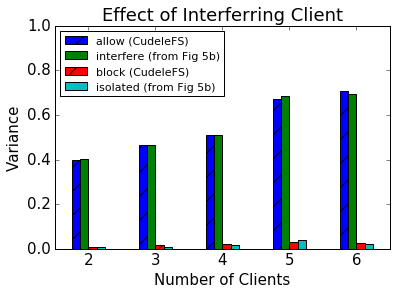

In [26]:

fig, ax = plt.subplots(1, 1)



# baseline: 100K isolated creates
site = 'experiments/fuse/consistency/results-old/nojournal-nocache/mdtest*'
base = parse_mdtest(glob.glob(site + 'isolated-9800*'))
norm = np.mean(base)

# client scaling experiment
mean = pd.DataFrame(columns=["allow (CudeleFS)", "interfere (from Fig 5b)", "block (CudeleFS)", "isolated (from Fig 5b)"])
stds = pd.DataFrame(columns=["allow (CudeleFS)", "interfere (from Fig 5b)", "block (CudeleFS)", "isolated (from Fig 5b)"])
for n in [2, 3, 4, 5, 6]:
    site = 'experiments/fuse/scale-clients-isolated/results-paper/creates-touchstream-'+str(n)+'-decoupled-1/*/mdtest-'
    decoupled = parse_mdtest(glob.glob(site + 'interfere-9800*'))
    site = 'experiments/fuse/scale-clients-isolated/results-paper/creates-touchstream-'+str(n)+'-decoupled-0/*/mdtest-'    
    not_decoupled = parse_mdtest(glob.glob(site + 'interfere-9800*'))
    site = 'experiments/fuse/scale-clients/results-touchstream/creates-*'+str(n)+'*/*/mdtest-'
    interfer = parse_mdtest(glob.glob(site + 'interfere-9800*'))
    isolated = parse_mdtest(glob.glob(site + 'isolated-9800*'))    
    mean.loc[len(mean)] = [np.mean(not_decoupled/norm), np.mean(interfer/norm), np.mean(decoupled/norm), np.mean(isolated/norm)]
    stds.loc[len(stds)] = [np.std(not_decoupled/norm), np.std(interfer/norm), np.std(decoupled/norm), np.std(isolated/norm)] 

print mean
print stds
stds.plot.bar(ax=ax)
ax.set_xticklabels(range(2, 9), rotation=0)
ax.set_title("Effect of Interferring Client")
ax.set_xlabel("Number of Clients")
ax.set_ylabel("Variance")
#vals = ax.get_yticks()
#ax.set_yticklabels(['{:3.1f}x'.format(x*1) for x in vals] + ["4.0x"])
ax.set_ylim(0, 1)

bars = ax.patches
hatches = ''.join(h*len(mean) for h in '/ / ')
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
ax.legend(fontsize=11, loc='upper left', ncol=1)
font = {'size'   : 15}
matplotlib.rc('font', **font)

fig.savefig('paper/graphs/slowdown-allow-block.png', dpi=400)
